In [1]:
# We tell Python which tools we want to use.
import warnings
warnings.filterwarnings('ignore')  # hide non-critical warnings

import pandas as pd   # tables and data cleaning
import numpy as np    # math helpers
import matplotlib.pyplot as plt  # simple charts

# If you get an error "ModuleNotFoundError: No module named 'sklearn'",
# run this in a terminal:  pip install scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')  # pretty numbers


## Load the CSV and see the data

In [2]:
# Read the CSV file into a pandas DataFrame (a table).
PATH = "LossFromNetCrime(original).csv"
df = pd.read_csv(PATH)  # default encoding is utf-8

# Look at the shape (rows, columns) and the first 5 rows.
print("Shape:", df.shape)
df.head()


Shape: (117, 13)


,Country,2019_Complaints,2019_Losses,2020_Complaints,2020_Losses,2021_Complaints,2021_Losses,2022_Complaints,2022_Losses,2023_Complaints,2023_Losses,2024_Complaints,2024_Losses
0,PR,655,5929974,1338,7209755,1785,9463928,1594,17211758,1817,21018302,1974,31545772
1,PS,1784,22483591,2890,25423219,3352,48918464,3210,57796003,3378,69292891,3811,66002407
2,PT,1119,13870074,2020,12391290,2102,18205913,1918,30859319,2178,28700418,2209,40192274
3,PY,1913,10967865,2992,13815152,3188,26677869,3768,40114594,3487,33579643,2678,45168957
4,AE,5503,48101706,7390,81178182,10164,131934602,10042,187062157,11034,244238485,12071,280815215


## Basic checks and actual data cleaning

In [3]:
# 1) Check any missing values per column.
print("Missing values per column:\n", df.isna().sum())

# 2) Fix missing Country so grouping works later.
df['Country'] = df['Country'].fillna('Unknown')

# 3) Ensure all numeric columns are truly numbers (not strings).
num_cols = [c for c in df.columns if c.endswith('_Complaints') or c.endswith('_Losses')]
for c in num_cols:
    # If the file ever had commas like "12,345", uncomment the next line:
    # df[c] = df[c].astype(str).str.replace(',', '', regex=False)
    df[c] = pd.to_numeric(df[c], errors='raise')

# 4) Confirm data types.
print("\nData types:\n", df.dtypes)

# 5) Quick overall stats (count, mean, std, min, max...) on numeric columns.
df.describe()


Missing values per column:
 Country            1
2019_Complaints    0
2019_Losses        0
2020_Complaints    0
2020_Losses        0
2021_Complaints    0
2021_Losses        0
2022_Complaints    0
2022_Losses        0
2023_Complaints    0
2023_Losses        0
2024_Complaints    0
2024_Losses        0
dtype: int64

Data types:
 Country            object
2019_Complaints     int64
2019_Losses         int64
2020_Complaints     int64
2020_Losses         int64
2021_Complaints     int64
2021_Losses         int64
2022_Complaints     int64
2022_Losses         int64
2023_Complaints     int64
2023_Losses         int64
2024_Complaints     int64
2024_Losses         int64
dtype: object


,2019_Complaints,2019_Losses,2020_Complaints,2020_Losses,2021_Complaints,2021_Losses,2022_Complaints,2022_Losses,2023_Complaints,2023_Losses,2024_Complaints,2024_Losses
count,117.00,117.00,117.00,117.00,117.00,117.00,117.00,117.00,117.00,117.00,117.00,117.00
mean,"24,650.38","236,637,011.62","43,248.50","281,182,227.68","45,730.71","471,280,297.50","42,983.98","719,554,651.11","45,504.66","858,994,659.14","50,733.81","1,013,898,175.35"
std,"63,976.71","508,724,719.20","112,412.52","603,911,435.92","125,357.18","1,042,950,534.26","112,053.59","1,565,846,038.45","116,211.49","1,924,353,301.60","133,450.37","2,229,037,404.52"
min,216.00,"2,498,015.00",362.00,"2,673,181.00",391.00,"4,362,630.00",458.00,"6,648,059.00",400.00,"8,907,146.00",330.00,"9,792,860.00"
25%,"1,119.00","11,786,077.00","1,937.00","13,815,152.00","2,102.00","22,863,562.00","1,918.00","33,495,225.00","2,280.00","41,315,061.00","2,253.00","47,876,570.00"
50%,"5,156.00","45,713,939.00","8,187.00","45,286,391.00","9,415.00","100,042,024.00","8,819.00","127,649,437.00","9,527.00","163,144,740.00","9,251.00","187,551,761.00"
75%,"16,525.00","202,462,502.00","28,232.00","212,529,097.00","30,367.00","400,343,277.00","29,642.00","605,452,580.00","31,255.00","642,098,116.00","31,525.00","803,018,708.00"
max,"449,305.00","3,302,744,547.00","796,395.00","3,906,715,208.00","940,125.00","6,466,618,579.00","769,205.00","10,304,392,551.00","876,894.00","11,916,782,073.00","946,966.00","14,457,011,740.00"


## Make a tidy/long table (easier for analysis)

In [4]:
# We want one row per Country-Year with 4 columns:
# Country | Year | Complaints | Losses

years = [2019, 2020, 2021, 2022, 2023, 2024]

rows = []
for y in years:
    rows.append(pd.DataFrame({
        'Country': df['Country'],
        'Year': y,
        'Complaints': df[f'{y}_Complaints'],
        'Losses': df[f'{y}_Losses']
    }))
long_df = pd.concat(rows, ignore_index=True)

# Helpful scaled versions for readability
long_df['Complaints_M'] = long_df['Complaints'] / 1_000_000   # millions
long_df['Losses_B']     = long_df['Losses'] / 1_000_000_000   # billions

# A “severity” metric: average loss per complaint
long_df['Loss_per_Complaint'] = np.where(
    long_df['Complaints'] > 0,
    long_df['Losses'] / long_df['Complaints'],
    np.nan
)

print("long_df shape:", long_df.shape)
long_df.head()


long_df shape: (702, 7)


,Country,Year,Complaints,Losses,Complaints_M,Losses_B,Loss_per_Complaint
0,PR,2019,655,5929974,0.00,0.01,"9,053.40"
1,PS,2019,1784,22483591,0.00,0.02,"12,602.91"
2,PT,2019,1119,13870074,0.00,0.01,"12,395.06"
3,PY,2019,1913,10967865,0.00,0.01,"5,733.33"
4,AE,2019,5503,48101706,0.01,0.05,"8,741.00"


## Yearly totals + year-over-year change

Year-over-Year puts both series in percent, so they're directly comparable.

In [5]:
# Sum across countries to get global totals per year
yearly = long_df.groupby('Year', as_index=True).agg(
    Complaints=('Complaints', 'sum'),
    Losses=('Losses', 'sum')
)

# Also compute scaled units
yearly['Complaints_M'] = yearly['Complaints'] / 1_000_000
yearly['Losses_B']     = yearly['Losses'] / 1_000_000_000

# YoY change in percent (how much did it grow vs last year?)
yoy_pct = yearly[['Complaints','Losses']].pct_change() * 100

print("Yearly totals (with scaled units):")
print(yearly)

print("\nYoY change (%):")
print(yoy_pct.round(2))


Yearly totals (with scaled units):
      Complaints        Losses  Complaints_M  Losses_B
Year                                                  
2019     2884094   27686530359          2.88     27.69
2020     5060074   32898320639          5.06     32.90
2021     5350493   55139794808          5.35     55.14
2022     5029126   84187894180          5.03     84.19
2023     5324045  100502375119          5.32    100.50
2024     5935856  118626086516          5.94    118.63

YoY change (%):
      Complaints  Losses
Year                    
2019         NaN     NaN
2020       75.45   18.82
2021        5.74   67.61
2022       -6.01   52.68
2023        5.86   19.38
2024       11.49   18.03


## Descriptive stats (simple)

In [6]:
# Descriptive statistics on scaled units (easier to read)
desc_scaled = long_df[['Complaints_M', 'Losses_B', 'Loss_per_Complaint']].describe()
print("Descriptive stats (scaled units):")
print(desc_scaled.round(2))


Descriptive stats (scaled units):
       Complaints_M  Losses_B  Loss_per_Complaint
count        702.00    702.00              702.00
mean           0.04      0.60           16,126.42
std            0.11      1.49           10,538.80
min            0.00      0.00            2,961.32
25%            0.00      0.03            8,809.30
50%            0.01      0.10           13,338.16
75%            0.03      0.43           20,324.04
max            0.95     14.46           77,078.40


## Correlation (overall + per-year)

In [7]:
# Overall correlation across all Country-Year rows
overall_corr = long_df[['Complaints', 'Losses']].corr().iloc[0,1]
print(f"Overall Pearson correlation (Complaints vs Losses): {overall_corr:.3f}")

# Per-year correlation: within each year, across countries
per_year_corr = (
    long_df.groupby('Year')[['Complaints', 'Losses']]
           .corr()
           .unstack()
           .iloc[:,1]  # Complaints vs Losses cell
           .sort_index()
)
print("\nPer-year correlation (Complaints vs Losses):")
print(per_year_corr.round(3))


Overall Pearson correlation (Complaints vs Losses): 0.846

Per-year correlation (Complaints vs Losses):
Year
2019   0.92
2020   0.92
2021   0.88
2022   0.93
2023   0.89
2024   0.93
Name: (Complaints, Losses), dtype: float64


Closer to 1.0 means they move together strongly (countries with more complaints tend to show more losses).

## Predictive model

We’ll predict Losses using Complaints and a simple time trend. Because money is skewed (some countries are huge), we model the log of losses to make things stable.

In [8]:
# Train on 2019-2023, test on 2024
train = long_df[long_df['Year'] < 2024].copy()
test  = long_df[long_df['Year'] == 2024].copy()

# Features (inputs) for the model:
# - log1p_Complaints: log(1 + Complaints) handles very big numbers safely
# - YearOffset: 0 for the first year, then 1,2,3... (a simple time trend)
X_train = pd.DataFrame({
    'log1p_Complaints': np.log1p(train['Complaints']),
    'YearOffset': train['Year'] - train['Year'].min()
})
y_train = np.log1p(train['Losses'])  # target on log scale

X_test = pd.DataFrame({
    'log1p_Complaints': np.log1p(test['Complaints']),
    'YearOffset': test['Year'] - train['Year'].min()
})

# Fit a linear regression on the log scale
model = LinearRegression()
model.fit(X_train, y_train)

# Predict 2024 on the log scale, then convert back with expm1
log_pred = model.predict(X_test)
pred_losses = np.expm1(log_pred)  # dollars

# Evaluate:
# R^2 on the log scale (how well the model explains variation)
r2  = r2_score(np.log1p(test['Losses']), log_pred)

# MAE: average absolute error in dollars
mae = mean_absolute_error(test['Losses'], pred_losses)

# RMSE: root mean squared error (handle older sklearn without 'squared=')
try:
    rmse = mean_squared_error(test['Losses'], pred_losses, squared=False)
except TypeError:
    rmse = np.sqrt(mean_squared_error(test['Losses'], pred_losses))

print("\n=== 2024 evaluation ===")
print(f"R^2 (log scale): {r2:.3f}")
print(f"MAE:  ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")

# See a few predictions vs actuals (top by actual loss)
pred_2024 = test[['Country', 'Year', 'Complaints', 'Losses']].copy()
pred_2024['Predicted_Losses'] = pred_losses
pred_2024['Error'] = pred_2024['Predicted_Losses'] - pred_2024['Losses']
pred_2024['APE_%'] = (pred_2024['Error'].abs() / pred_2024['Losses']) * 100

print("\nSample (top 10 by actual losses):")
print(
    pred_2024.sort_values('Losses', ascending=False)
             .head(10)
             .assign(
                 Losses_B=lambda d: d['Losses']/1e9,
                 Predicted_B=lambda d: d['Predicted_Losses']/1e9
             )[[
                 'Country','Complaints','Losses_B','Predicted_B','APE_%'
             ]].round({'Losses_B':2,'Predicted_B':2,'APE_%':2})
)



=== 2024 evaluation ===
R^2 (log scale): 0.931
MAE:  $418,681,774
RMSE: $1,076,318,434

Sample (top 10 by actual losses):
    Country  Complaints  Losses_B  Predicted_B  APE_%
634      US      946966     14.46        19.41  34.24
620      CN      868309     11.30        17.84  57.87
602      RU      324091     11.16         6.85  38.67
645      GB      481671      6.38        10.06  57.72
627      DE      146731      5.28         3.17  39.97
632      UA      160414      5.16         3.46  33.04
610      SG      161666      4.52         3.48  23.03
659      IN       98092      4.16         2.14  48.54
644      FR      208832      4.03         4.47  10.94
667      JP      182470      3.39         3.92  15.43


## Visualization Code (KEEP AT THE END TO PREVENT ERRORS ON OTHER COMPUTERS)

## Year-over-Year chart (puts both series on the same scale) in percent - so that they're directly comparable.

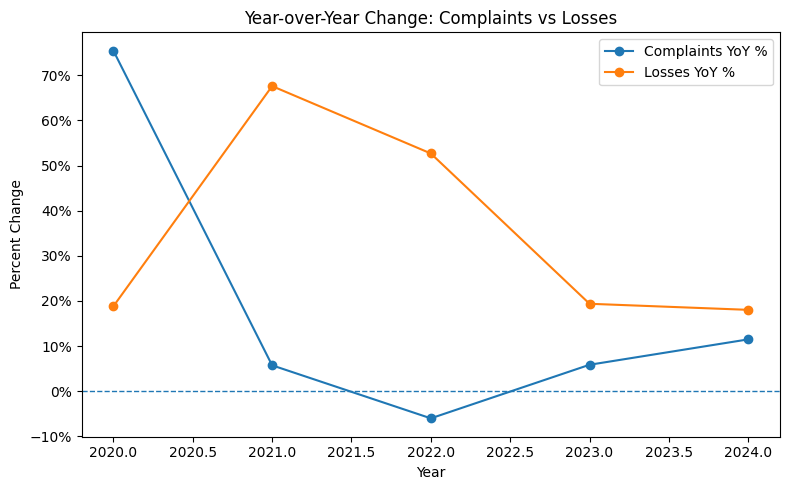

In [9]:
from matplotlib.ticker import PercentFormatter

yoy = yearly[['Complaints','Losses']].pct_change() * 100
yoy = yoy.dropna()  # first year has no previous year to compare

plt.figure(figsize=(8, 5))
plt.plot(yoy.index, yoy['Complaints'], marker='o', label='Complaints YoY %')
plt.plot(yoy.index, yoy['Losses'], marker='o', label='Losses YoY %')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Year-over-Year Change: Complaints vs Losses')
plt.xlabel('Year'); plt.ylabel('Percent Change')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend(); plt.tight_layout(); plt.show()


Each point shows how much the total changed compared to the previous year.
Positive = increased, negative = decreased.
Using percent value puts both lines on the same scale.

## Correlation heatmap (focused on what matters)

What it shows: how strongly pairs of variables move together (1 = very strong positive, 0 = none, -1 = strong negative).

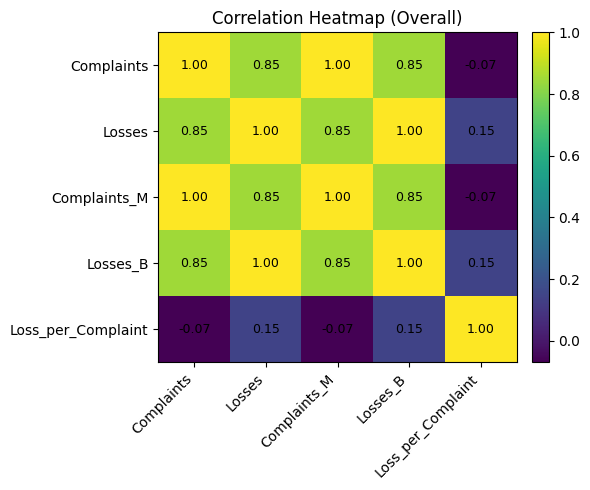

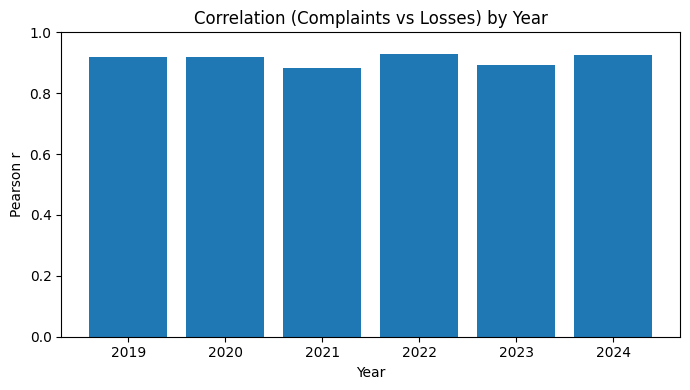

In [10]:
# Overall correlation between key variables
corr_cols = ['Complaints', 'Losses', 'Complaints_M', 'Losses_B', 'Loss_per_Complaint']
corr = long_df[corr_cols].corr(method='pearson')

plt.figure(figsize=(6,5))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Correlation Heatmap (Overall)')
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
plt.yticks(range(len(corr_cols)), corr_cols)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', fontsize=9)
plt.tight_layout(); plt.show()

# Per-year correlation bar chart (Complaints vs Losses)
per_year_corr = (
    long_df.groupby('Year')[['Complaints','Losses']]
           .corr()
           .unstack()
           .iloc[:,1]
           .sort_index()
)
plt.figure(figsize=(7,4))
plt.bar(per_year_corr.index.astype(str), per_year_corr.values)
plt.ylim(0, 1)
plt.title('Correlation (Complaints vs Losses) by Year')
plt.xlabel('Year'); plt.ylabel('Pearson r')
plt.tight_layout(); plt.show()


Heatmap: darker squares = stronger relationships. Expect strong positive between complaints and losses.

Per-year bar chart: shows that within each year, countris with more complaints also tend to report more losses (high bars near the value 1.0)

## Predictive model visuals (optional)

## Predicted vs Actual (2024)

This shows how close our predictions are to reality in 2024. Points on the diagonal are perfect; above = over-predict, below = under-predict. The model is trained on 2019-2023, 2024 is out-of-sample.

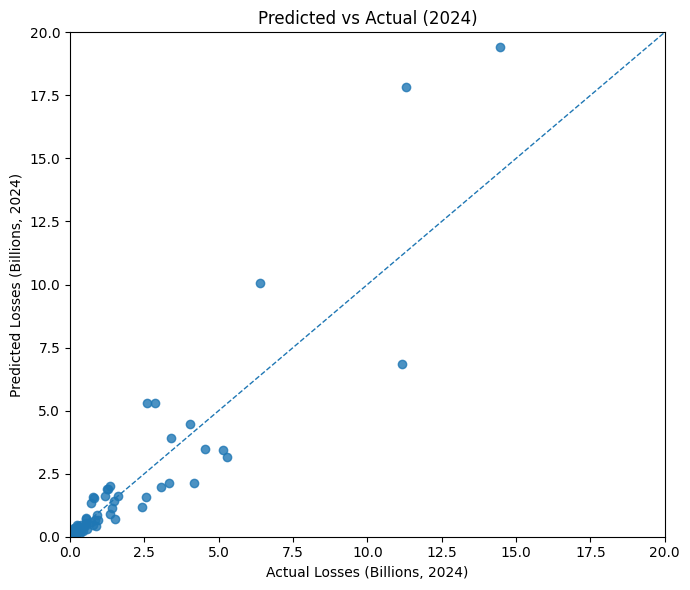

In [11]:
actual_B = pred_2024['Losses'] / 1e9
pred_B   = pred_2024['Predicted_Losses'] / 1e9

plt.figure(figsize=(7,6))
plt.scatter(actual_B, pred_B, alpha=0.8)
lim = float(np.ceil(max(actual_B.max(), pred_B.max())))
plt.plot([0, lim], [0, lim], linestyle='--', linewidth=1)
plt.xlim(0, lim); plt.ylim(0, lim)
plt.xlabel('Actual Losses (Billions, 2024)')
plt.ylabel('Predicted Losses (Billions, 2024)')
plt.title('Predicted vs Actual (2024)')
plt.tight_layout(); plt.show()


## Residuals (are errors random?):

These help us to see if the model is systematically over/under-predicting.
If points are scattered randomly around 0, it means the errors are not obviously biased.
If residuals grow as predictions grow (a "fan" shape), variance may increase with size - consider different modeling method or transformations.


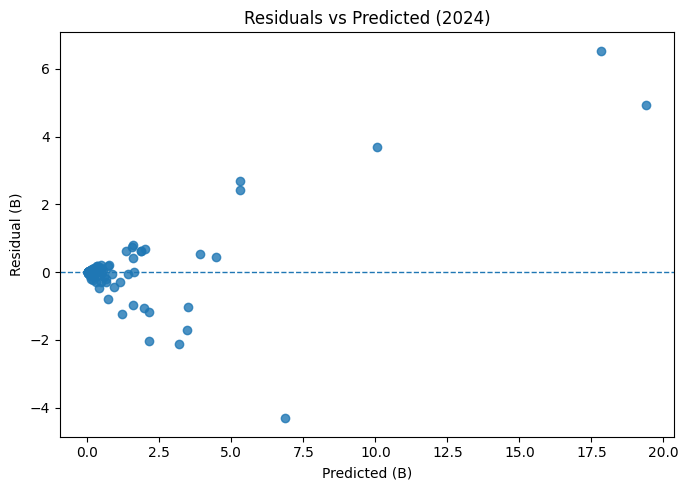

In [12]:
resid_B = pred_B - actual_B

plt.figure(figsize=(7,5))
plt.scatter(pred_B, resid_B, alpha=0.8)
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel('Predicted (B)'); plt.ylabel('Residual (B)')
plt.title('Residuals vs Predicted (2024)')
plt.tight_layout(); plt.show()


## Saving cleaned data and predictions:

In [13]:
df.to_csv("cleaned_wide.csv", index=False)
long_df.to_csv("cleaned_long.csv", index=False)
pred_2024.to_csv("predictions_2024.csv", index=False)
print("Saved: cleaned_wide.csv, cleaned_long.csv, predictions_2024.csv")


Saved: cleaned_wide.csv, cleaned_long.csv, predictions_2024.csv
